In [1]:
#MURA dataset is located in my googe drive, can also mount from file system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn import preprocessing
from skimage import io
import os
from PIL import Image
import torch
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [66]:
#import test and valid csv's from google drive

train = pd.read_csv('drive/MyDrive/MURA-v1.1/train_labeled_studies.csv', header = None, names = ['image_path', 'target'])
test = pd.read_csv('drive/MyDrive/MURA-v1.1/valid_labeled_studies.csv', header = None, names = ['image_path', 'target'])

# Analysis with 2 targets

In [67]:
train.head()

,image_path,target
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [68]:
test.head()

,image_path,target
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_positive/,1


In [69]:
print(f'train:{train.shape}\ntest:{test.shape}')

train:(13457, 2)
test:(1199, 2)


In [70]:
#helper funtion to extract info from train and test dataframes
def clean_df(df):
  temp = df['image_path'].str.split('/', expand=True)
  new_df = pd.DataFrame(df['image_path'])
  new_df['patient_id'] = temp[3]
  new_df['study'] = temp[4].str.split('_', expand = True)[0].str[-1:].astype(int)
  new_df['study_type'] = temp[4].str.split('_', expand = True)[1]
  new_df['region'] = temp[2].str.split('_', expand = True)[1]
  new_df['target'] = df['target']
  map = {'positive':'abnormal', 'negative':'normal'}
  new_df['study_type'] = new_df['study_type'].map(map)
  map1 = {1:'abnormal', 0:'normal'}
  new_df['target'] = new_df['target'].map(map1)
  #add google drive location to image path
  new_df['image_path'] = 'drive/MyDrive/' + new_df['image_path']

  return new_df

In [71]:
train = clean_df(train)
test = clean_df(test)

In [72]:
train.dtypes

image_path    object
patient_id    object
study          int64
study_type    object
region        object
target        object
dtype: object

In [73]:
train.head()

,image_path,patient_id,study,study_type,region,target
0,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,patient00001,1,abnormal,SHOULDER,abnormal
1,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,patient00002,1,abnormal,SHOULDER,abnormal
2,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,patient00003,1,abnormal,SHOULDER,abnormal
3,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,patient00004,1,abnormal,SHOULDER,abnormal
4,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,patient00005,1,abnormal,SHOULDER,abnormal


In [74]:
test.head()

,image_path,patient_id,study,study_type,region,target
0,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,patient11185,1,abnormal,WRIST,abnormal
1,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,patient11186,1,abnormal,WRIST,abnormal
2,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/,patient11186,2,abnormal,WRIST,abnormal
3,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/,patient11186,3,abnormal,WRIST,abnormal
4,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11187/study1_positive/,patient11187,1,abnormal,WRIST,abnormal


In [75]:
all_data = train.append(test)

<ipython-input-75-d4514d742969>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = train.append(test)


In [76]:
print(all_data[all_data['study_type']=='abnormal']['target'].unique())
print(all_data[all_data['study_type']=='normal']['target'].unique())

['abnormal']
['normal']


In [77]:
print(f'train:{train.shape}\ntest:{test.shape}\nall_data:{all_data.shape}')

train:(13457, 6)
test:(1199, 6)
all_data:(14656, 6)


In [78]:
# gets unique values of relevant rows
def get_unique(df):
  print(df['study'].unique())
  print(df['study_type'].unique())
  print(df['region'].unique())
  print(df['target'].unique())

In [79]:
get_unique(test)
get_unique(train)

[1 2 3 4]
['abnormal' 'normal']
['WRIST' 'FOREARM' 'HAND' 'HUMERUS' 'SHOULDER' 'ELBOW' 'FINGER']
['abnormal' 'normal']
[1 2 3 4]
['abnormal' 'normal']
['SHOULDER' 'HUMERUS' 'FINGER' 'ELBOW' 'WRIST' 'FOREARM' 'HAND']
['abnormal' 'normal']


In [80]:
# patient count by study with visulization
def study_count(df):
  stud_df = df.groupby('study').count()['image_path'].reset_index()
  stud_df.columns = ['Study','Count']
  display(stud_df)

  fig, ax = plt.subplots(figsize = (8,8))

  ax.bar(stud_df['Study'], stud_df['Count'], color = '#C8DDE7')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Studies', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Image Count', fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.tick_params(left = False, bottom = False)
  plt.title('Image Count by Study Amount', fontsize = 14, weight = 'bold')
  tot = stud_df['Count'].sum()
  plt.ylim(0,math.ceil(tot)*1.1)
  plt.show()

,Study,Count
0,1,12934
1,2,480
2,3,35
3,4,8


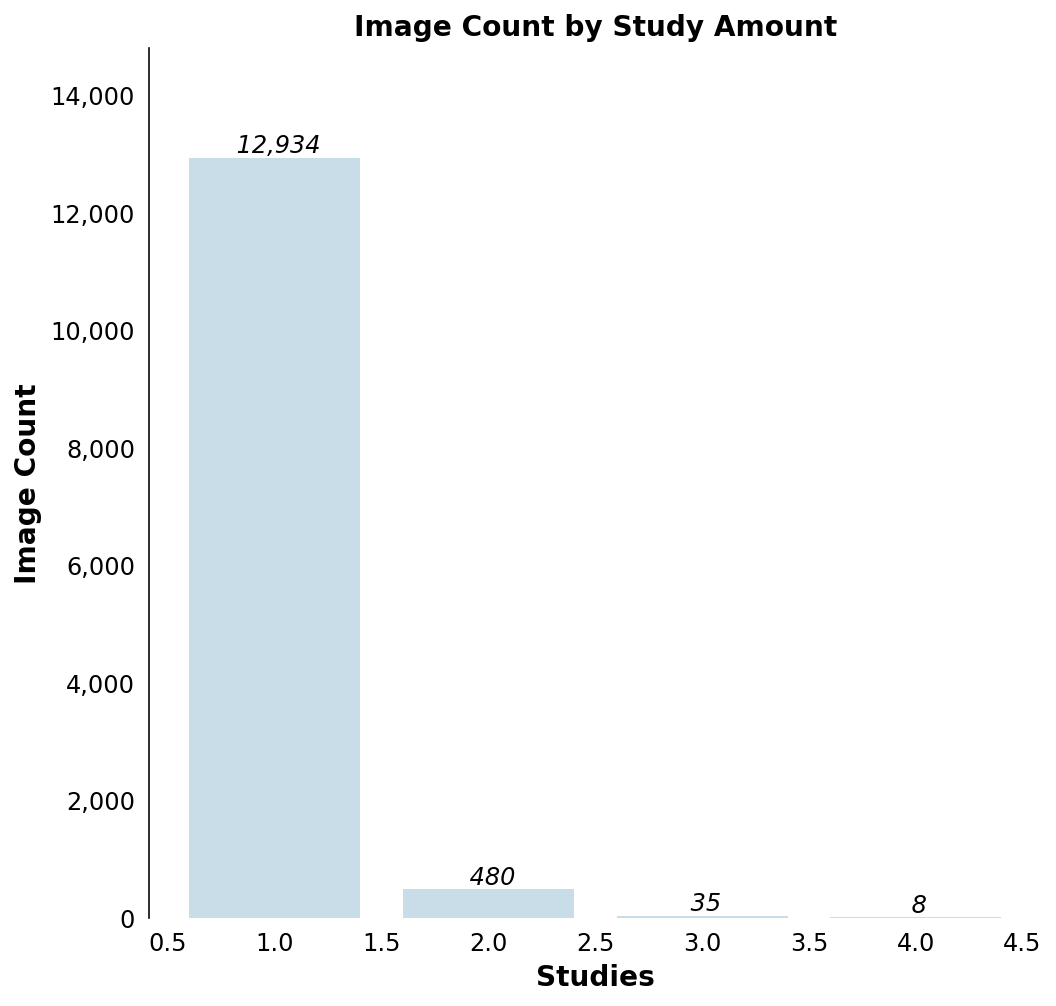

In [81]:
study_count(train)

,Study,Count
0,1,1118
1,2,70
2,3,10
3,4,1


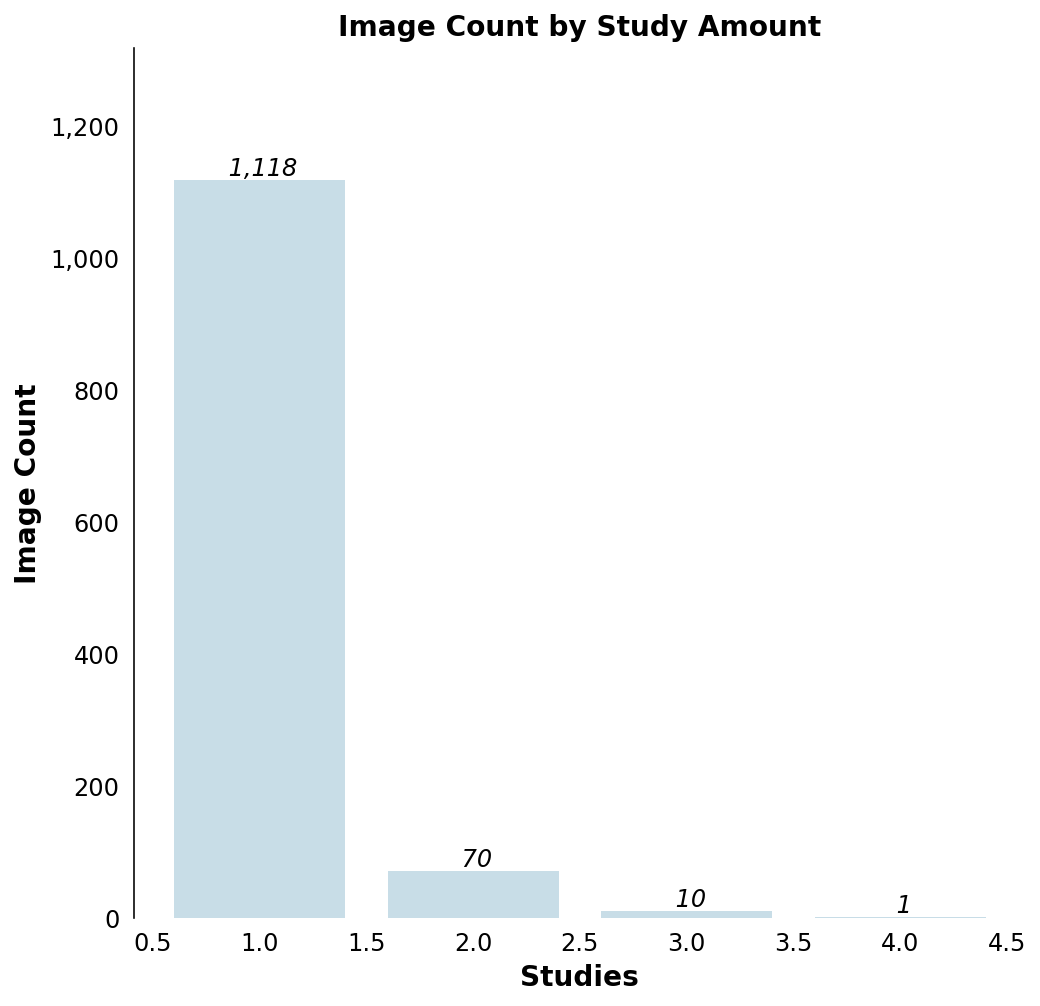

In [82]:
study_count(test)

,Study,Count
0,1,14052
1,2,550
2,3,45
3,4,9


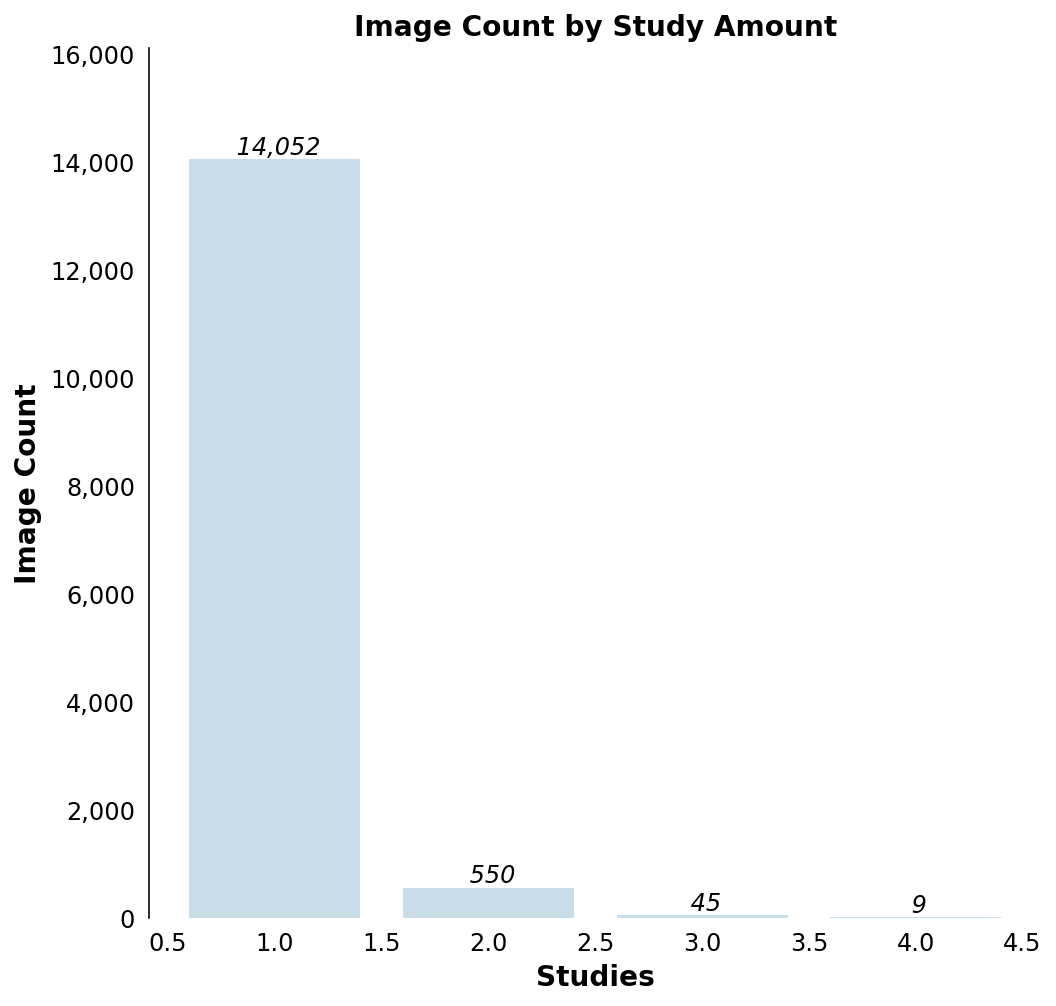

In [83]:
study_count(all_data)

In [84]:
# patient count by study type with visulization
def study_type_count(df):
  styp_df = df.groupby('study_type').count()['image_path'].reset_index()
  styp_df.columns = ['Study Type','Count']
  display(styp_df)

  fig, ax = plt.subplots(figsize = (8,8))

  ax.bar(styp_df['Study Type'], styp_df['Count'], color = '#0097a7')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Study Type', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Image Count', fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  tot = styp_df['Count'].sum()
  plt.ylim(0,math.ceil(tot)*.8)
  plt.tick_params(left = False, bottom = False)
  plt.title('Image Count by Study Type', fontsize = 14, weight = 'bold')
  plt.show()

,Study Type,Count
0,abnormal,5177
1,normal,8280


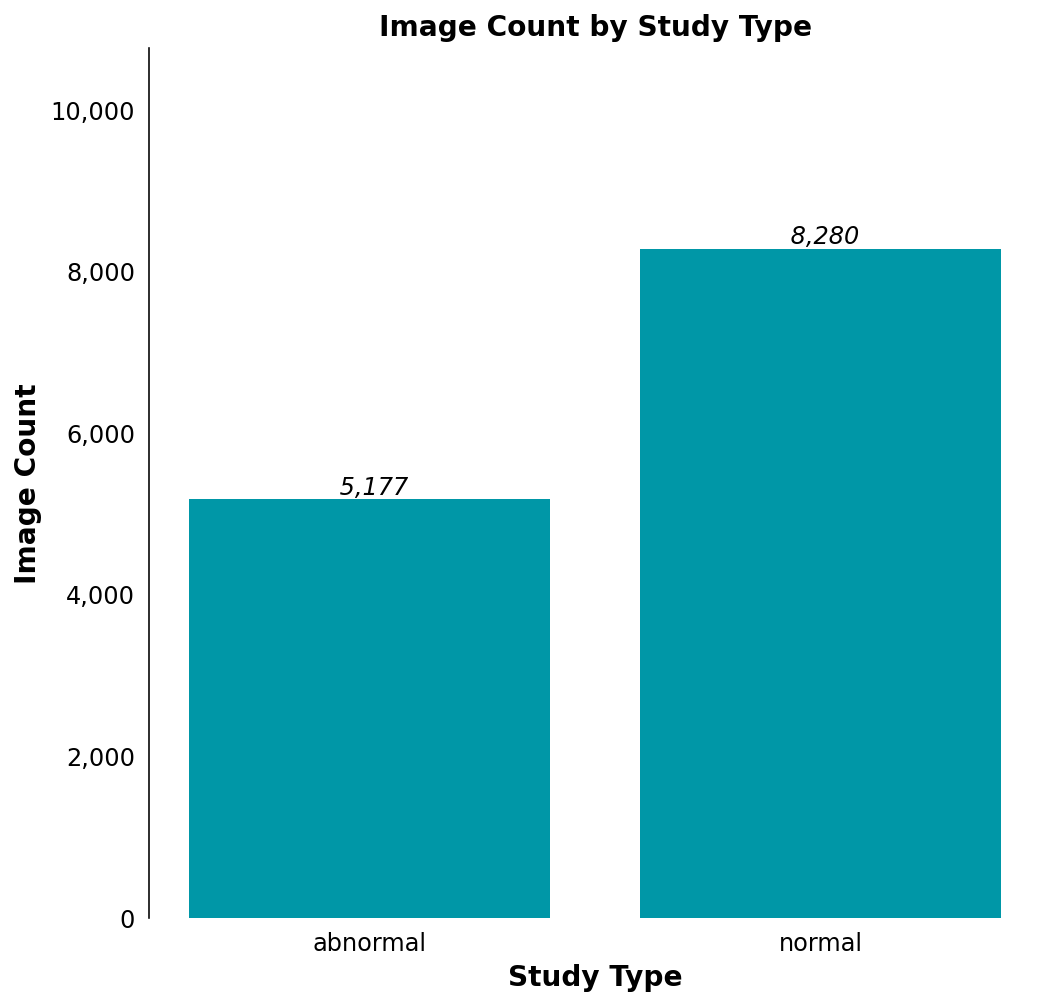

In [85]:
study_type_count(train)

,Study Type,Count
0,abnormal,538
1,normal,661


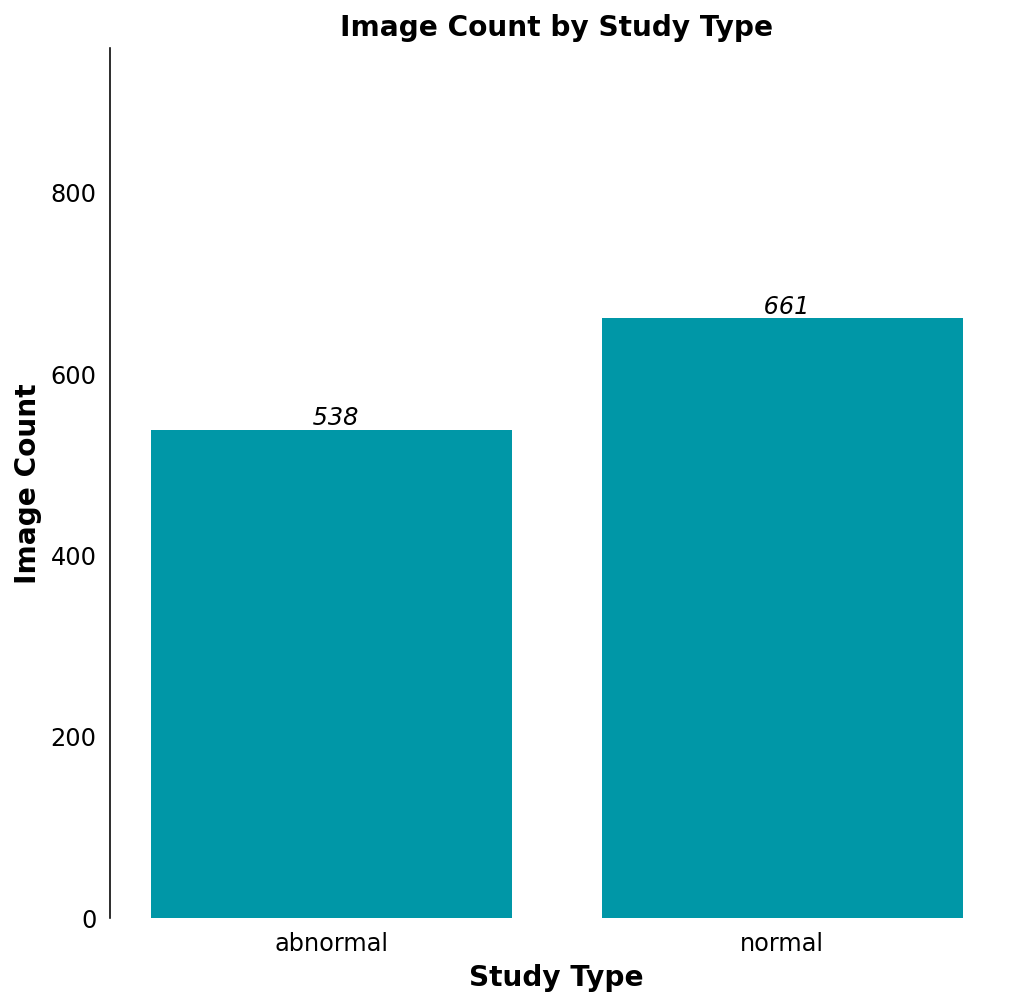

In [86]:
study_type_count(test)

,Study Type,Count
0,abnormal,5715
1,normal,8941


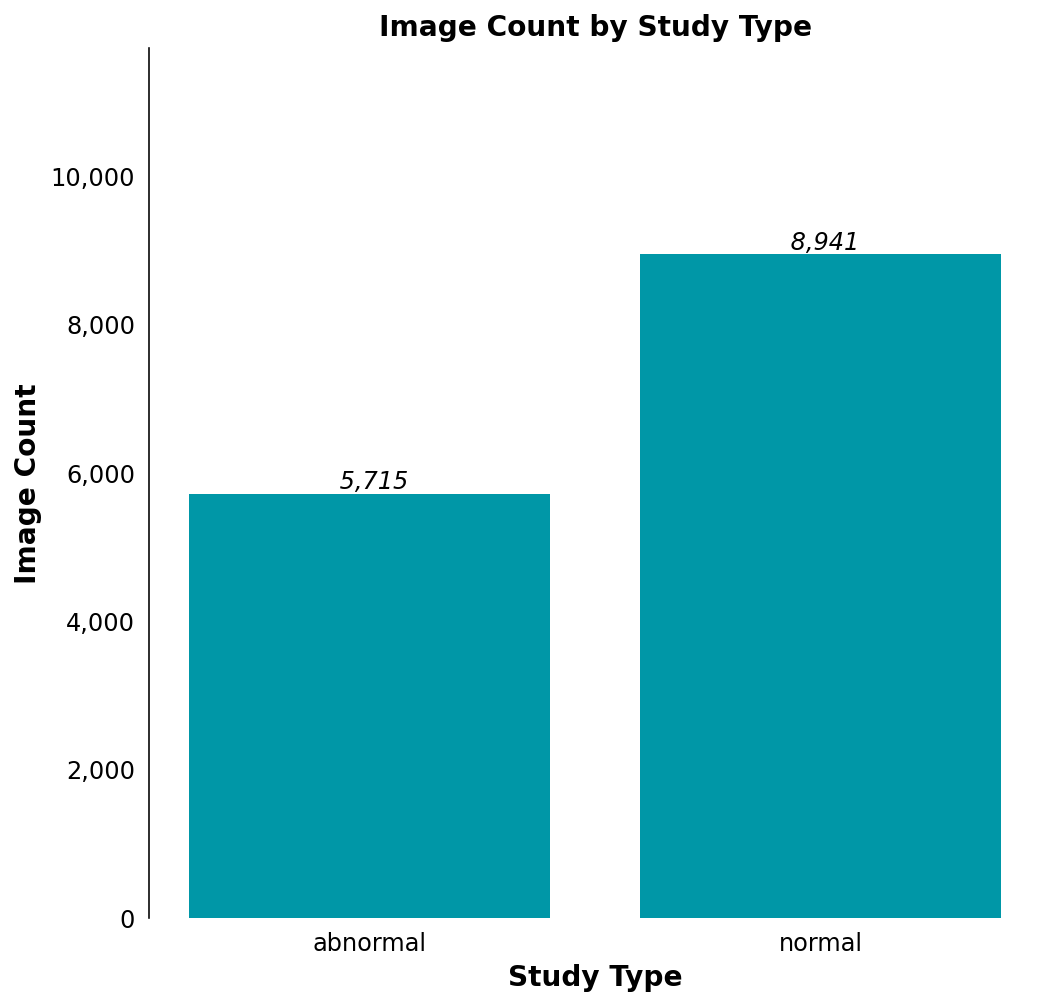

In [87]:
study_type_count(all_data)

In [88]:
#region count and visualisation
def region_count(df):
  # patient count by body part
  bdpt_df = df.groupby('region').count()['image_path'].reset_index()
  bdpt_df.columns = ['Region','Count']
  display(bdpt_df)

  # patient count by body part bargraph
  fig, ax = plt.subplots(figsize = (8,8))

  ax.barh(bdpt_df['Region'], bdpt_df['Count'], color = '#A8D3E3')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  plt.tick_params(left = False, bottom = False)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Region', fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.title('Image Count by Region', fontsize = 14, weight = 'bold')
  plt.show()

,Region,Count
0,ELBOW,1754
1,FINGER,1935
2,FOREARM,877
3,HAND,2018
4,HUMERUS,592
5,SHOULDER,2821
6,WRIST,3460


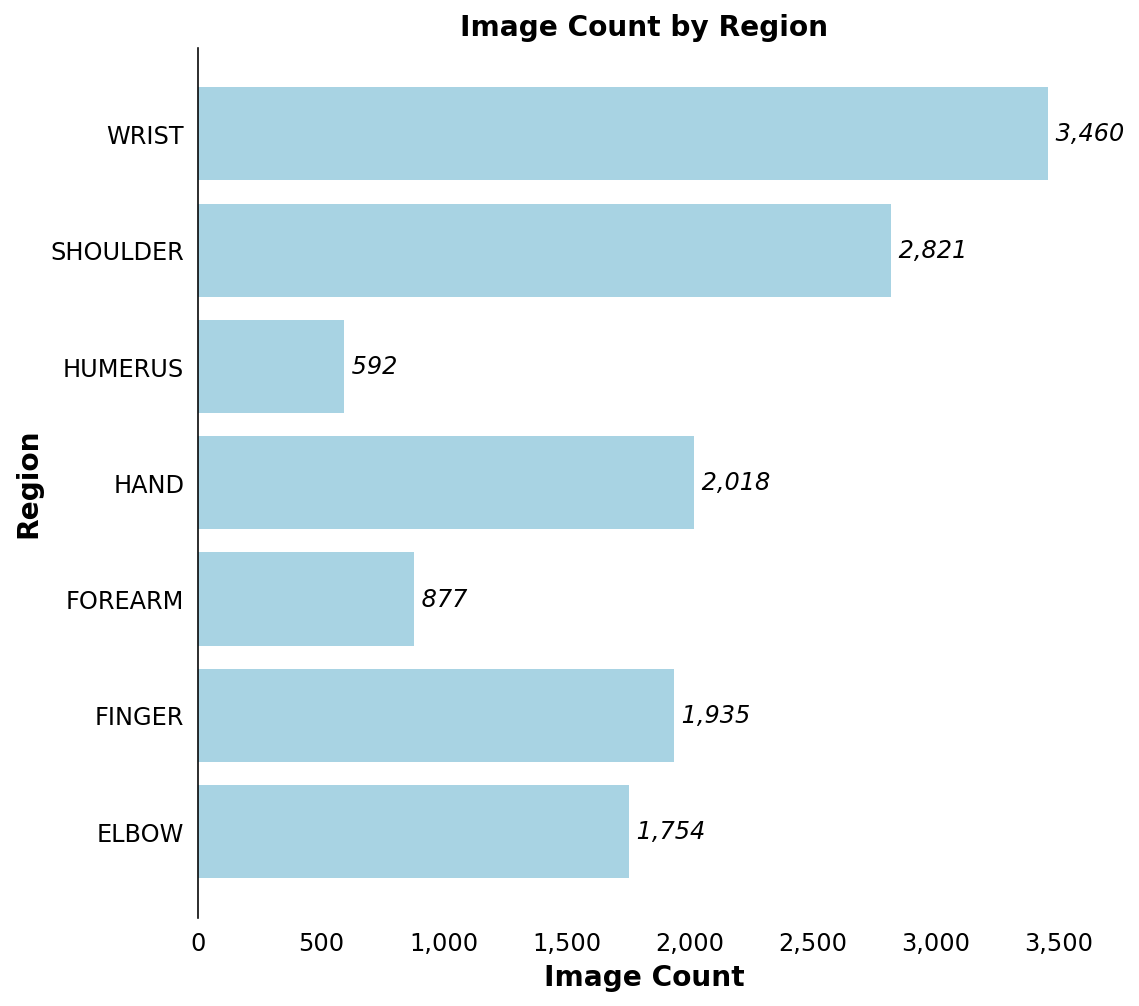

In [89]:
region_count(train)

,Region,Count
0,ELBOW,158
1,FINGER,175
2,FOREARM,133
3,HAND,167
4,HUMERUS,135
5,SHOULDER,194
6,WRIST,237


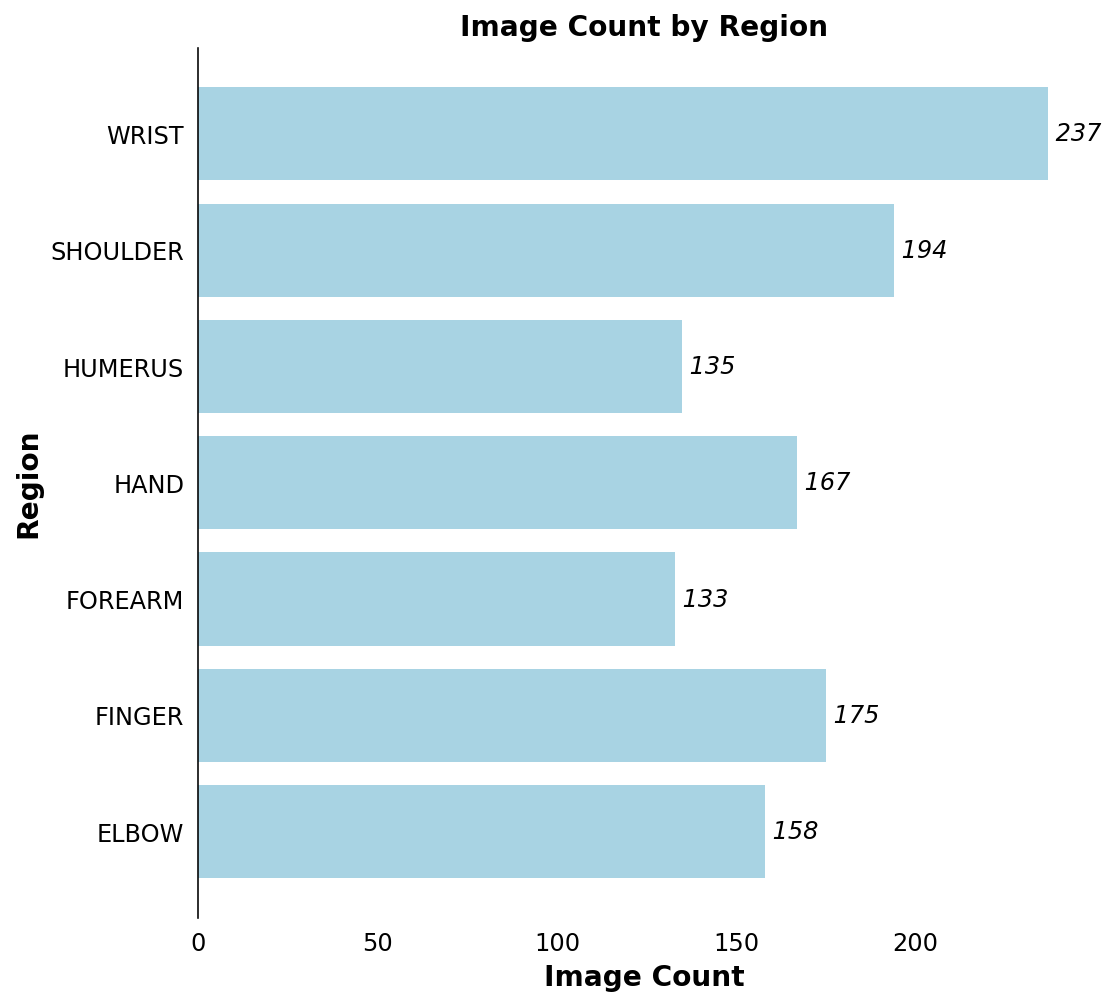

In [90]:
region_count(test)

,Region,Count
0,ELBOW,1912
1,FINGER,2110
2,FOREARM,1010
3,HAND,2185
4,HUMERUS,727
5,SHOULDER,3015
6,WRIST,3697


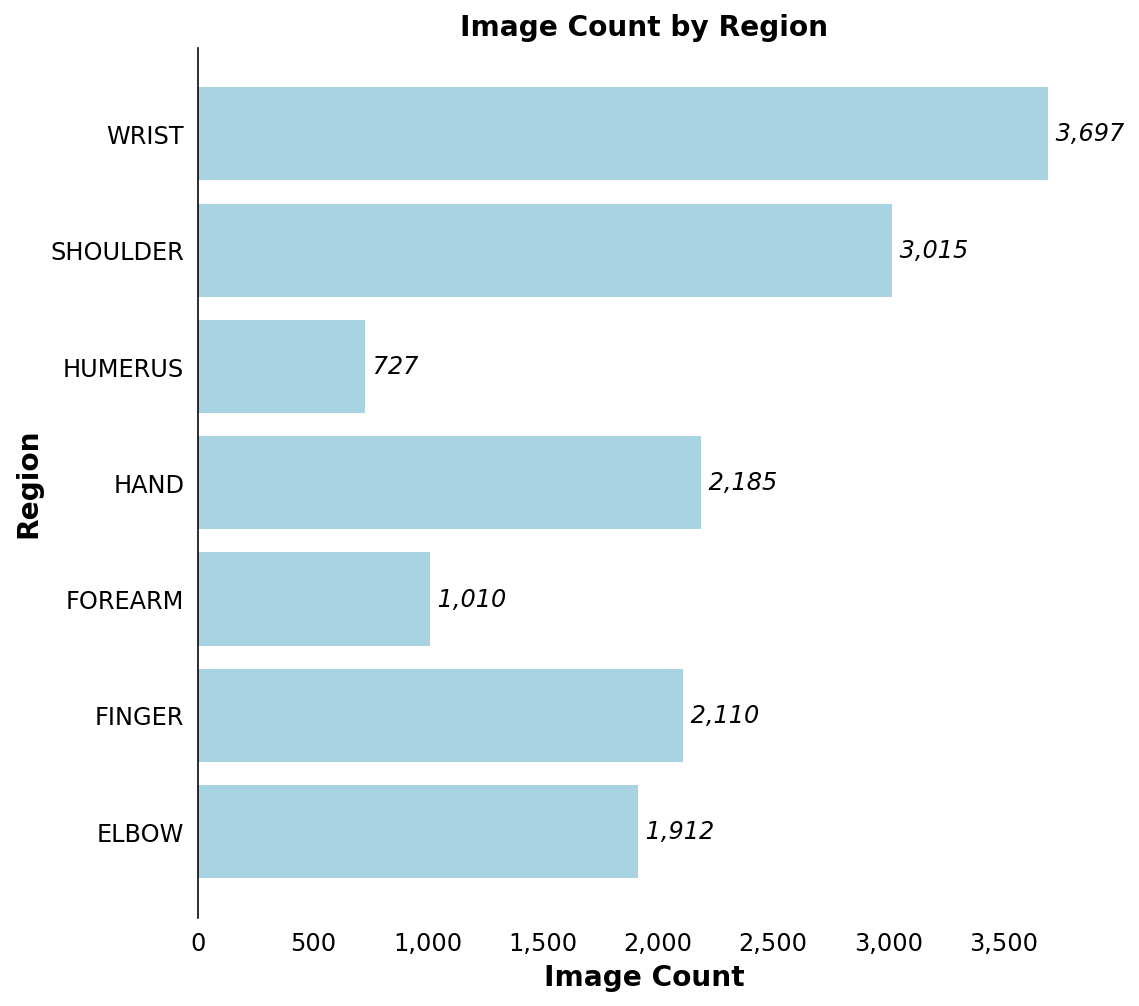

In [91]:
region_count(all_data)

In [92]:
# patient count by study type and region with visulization
def type_region(df):  
  stack = df.groupby(['region', 'study_type']).count()['image_path'].reset_index()
  stack.columns = ['Region','Study Type','Count']
  stack_neg = stack[stack['Study Type'] == 'normal']
  stack_pos = stack[stack['Study Type'] == 'abnormal']
  stack_all = stack_pos.merge(stack_neg, on = 'Region', how = 'left')
  stack_all['Count_z'] = stack_all['Count_x'] + stack_all['Count_y']
  display(stack_all)

  # patient count by study type and region stacked bargraph
  fig, ax = plt.subplots(figsize = (8,8))

  x = stack_all['Region']
  y1 = stack_all['Count_x']
  y2 = stack_all['Count_y']
  y3 = stack_all['Count_z']
  
  ax.barh(x, y1, color = '#A8D3E3', label = 'Abnormal')
  ax.barh(x, y2, left = y1, color = '#0097a7', label = 'Normal')
  container = ax.containers[0]
  container2 = ax.containers[1]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12, label_type = 'center')
  ax.bar_label(container2, labels = [' ' + f'{x:,.0f}' for x in container2.datavalues], style = 'italic', fontsize = 12, label_type = 'center')
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Region', fontsize = 14, weight = 'bold')
  ax.set_yticks(x, rotation = 90)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.tick_params(left = False, bottom = False)
  plt.title('Image Count by Study Type and Region', fontsize = 14, weight = 'bold')
  ax.legend()

  plt.show()

,Region,Study Type_x,Count_x,Study Type_y,Count_y,Count_z
0,ELBOW,abnormal,660,normal,1094,1754
1,FINGER,abnormal,655,normal,1280,1935
2,FOREARM,abnormal,287,normal,590,877
3,HAND,abnormal,521,normal,1497,2018
4,HUMERUS,abnormal,271,normal,321,592
5,SHOULDER,abnormal,1457,normal,1364,2821
6,WRIST,abnormal,1326,normal,2134,3460


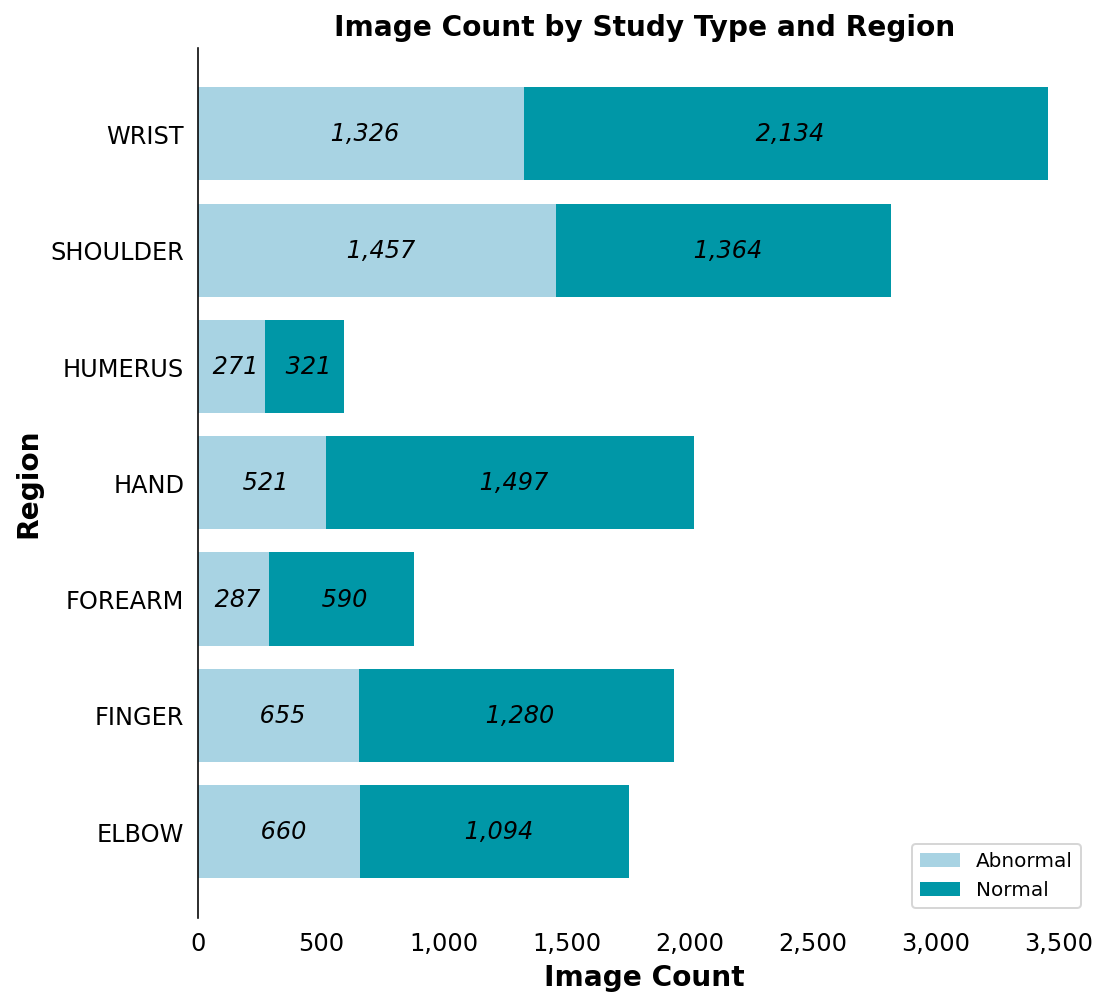

In [93]:
type_region(train)

,Region,Study Type_x,Count_x,Study Type_y,Count_y,Count_z
0,ELBOW,abnormal,66,normal,92,158
1,FINGER,abnormal,83,normal,92,175
2,FOREARM,abnormal,64,normal,69,133
3,HAND,abnormal,66,normal,101,167
4,HUMERUS,abnormal,67,normal,68,135
5,SHOULDER,abnormal,95,normal,99,194
6,WRIST,abnormal,97,normal,140,237


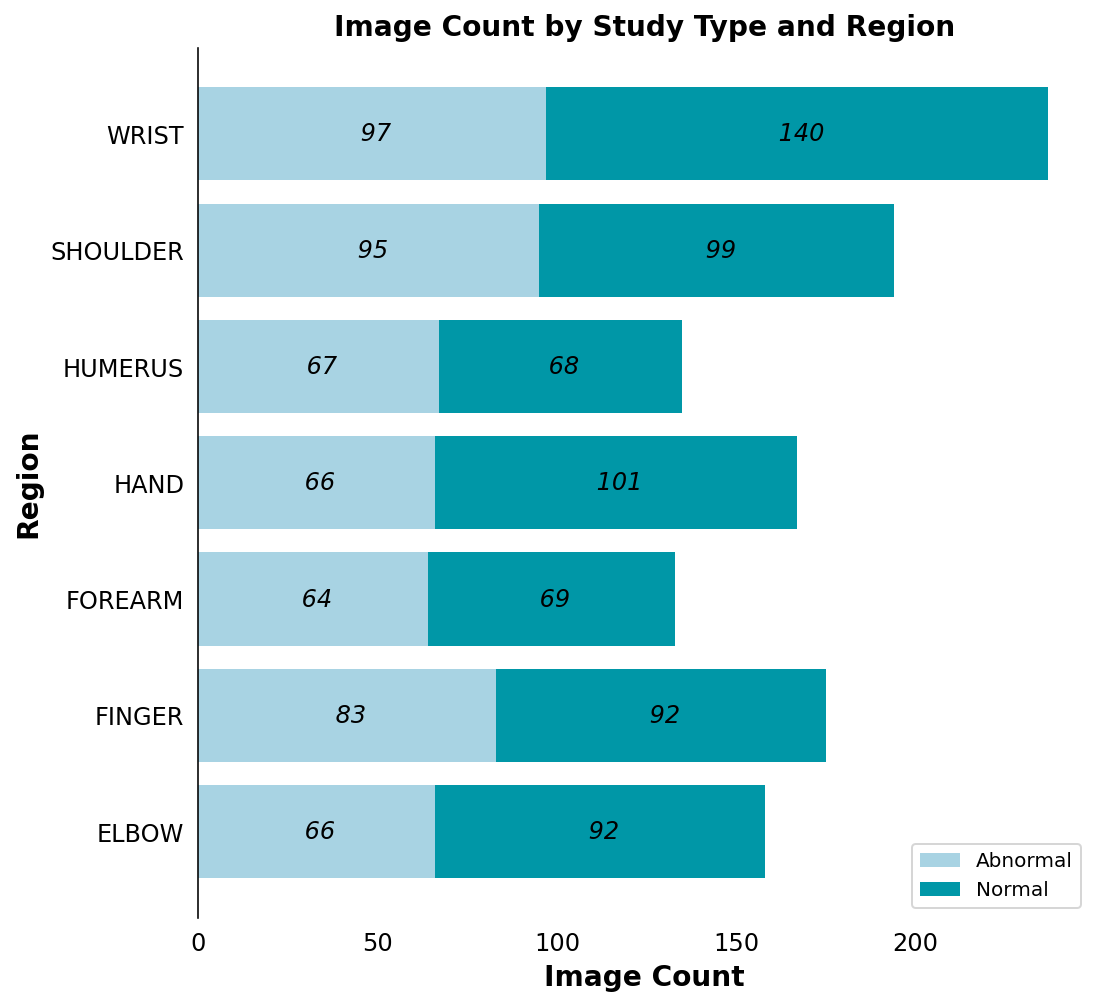

In [94]:
type_region(test)

,Region,Study Type_x,Count_x,Study Type_y,Count_y,Count_z
0,ELBOW,abnormal,726,normal,1186,1912
1,FINGER,abnormal,738,normal,1372,2110
2,FOREARM,abnormal,351,normal,659,1010
3,HAND,abnormal,587,normal,1598,2185
4,HUMERUS,abnormal,338,normal,389,727
5,SHOULDER,abnormal,1552,normal,1463,3015
6,WRIST,abnormal,1423,normal,2274,3697


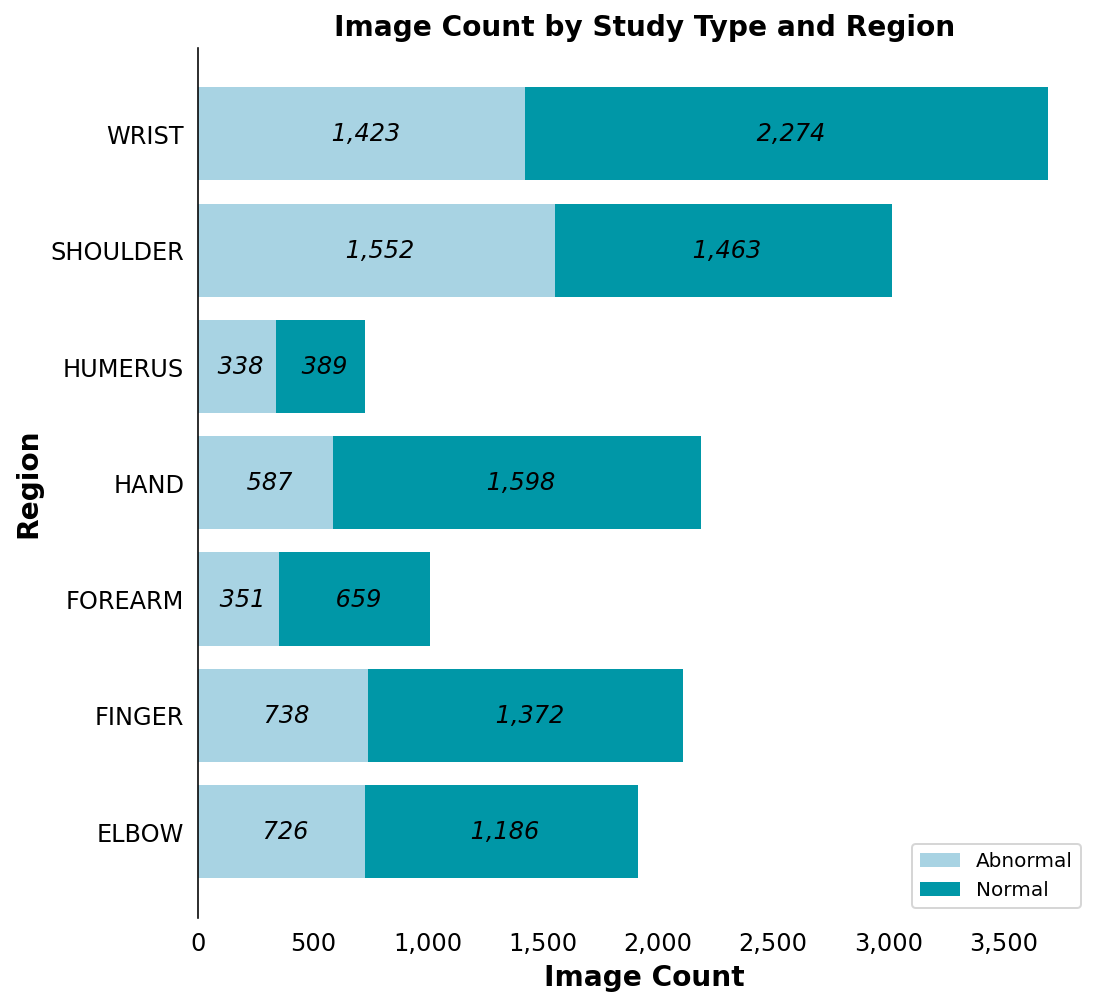

In [95]:
type_region(all_data)

# Analysis with 14 targets

In [96]:
#makes data combine target and region for new target variable
def make_new_target(df):
  df['type'] = df['study_type'] + "_" + df['region']
  df['new_target'] = df['region']+"_"+ df['target']

  target_map = {'WRIST_abnormal':'0', 'WRIST_normal':'1','FOREARM_abnormal' : '2', 'FOREARM_normal' : '3',
                      'HAND_abnormal': '4', 'HAND_normal' : '5', 'HUMERUS_abnormal': '6', 'HUMERUS_normal' : '7',
                      'ELBOW_abnormal': '8', 'ELBOW_normal' : '9', 'SHOULDER_abnormal' :'10', 'SHOULDER_normal': '11',
                      'FINGER_abnormal': '12', 'FINGER_normal' : '13'}

  df['target'] = df['new_target'].map(target_map)
  new_df = df[['image_path', 'patient_id','study_type',  'region', 'type','target']]
  return new_df

In [97]:
train_14 = make_new_target(train.copy())
test_14 = make_new_target(test.copy())

In [98]:
all_data_14 = train_14.append(test_14)

<ipython-input-98-4ba2ea82b4c5>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data_14 = train_14.append(test_14)


In [99]:
all_data_14.head()

,image_path,patient_id,study_type,region,type,target
0,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,patient00001,abnormal,SHOULDER,abnormal_SHOULDER,10
1,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,patient00002,abnormal,SHOULDER,abnormal_SHOULDER,10
2,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,patient00003,abnormal,SHOULDER,abnormal_SHOULDER,10
3,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,patient00004,abnormal,SHOULDER,abnormal_SHOULDER,10
4,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,patient00005,abnormal,SHOULDER,abnormal_SHOULDER,10


In [100]:
print(f'train:{train_14.shape}\ntest:{test_14.shape}\nall_data:{all_data_14.shape}')

train:(13457, 6)
test:(1199, 6)
all_data:(14656, 6)


In [101]:
def get_unique_14(df):
  print(df['type'].unique())
  print(df['target'].unique())

In [102]:
get_unique_14(test_14)
get_unique_14(train_14)

['abnormal_WRIST' 'normal_WRIST' 'abnormal_FOREARM' 'normal_FOREARM'
 'abnormal_HAND' 'normal_HAND' 'abnormal_HUMERUS' 'normal_HUMERUS'
 'abnormal_SHOULDER' 'normal_SHOULDER' 'abnormal_ELBOW' 'normal_ELBOW'
 'abnormal_FINGER' 'normal_FINGER']
['0' '1' '2' '3' '4' '5' '6' '7' '10' '11' '8' '9' '12' '13']
['abnormal_SHOULDER' 'normal_SHOULDER' 'abnormal_HUMERUS' 'normal_HUMERUS'
 'abnormal_FINGER' 'normal_FINGER' 'abnormal_ELBOW' 'normal_ELBOW'
 'abnormal_WRIST' 'normal_WRIST' 'abnormal_FOREARM' 'normal_FOREARM'
 'abnormal_HAND' 'normal_HAND']
['10' '11' '6' '7' '12' '13' '8' '9' '0' '1' '2' '3' '4' '5']


In [103]:
#patient count by study type with visulization
def study_type_count_14(df):
  styp_df = df.groupby('type').count()['image_path'].reset_index()
  styp_df.columns = ['type','Count']
  display(styp_df)

  fig, ax = plt.subplots(figsize = (10,10))

  ax.barh(styp_df['type'],styp_df['Count'],   color = '#0097a7')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  plt.tick_params(left = False, bottom = False)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Study Type' , fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.title('Image Count by Study Type', fontsize = 14, weight = 'bold')
  plt.show()
  return


,type,Count
0,abnormal_ELBOW,726
1,abnormal_FINGER,738
2,abnormal_FOREARM,351
3,abnormal_HAND,587
4,abnormal_HUMERUS,338
5,abnormal_SHOULDER,1552
6,abnormal_WRIST,1423
7,normal_ELBOW,1186
8,normal_FINGER,1372
9,normal_FOREARM,659


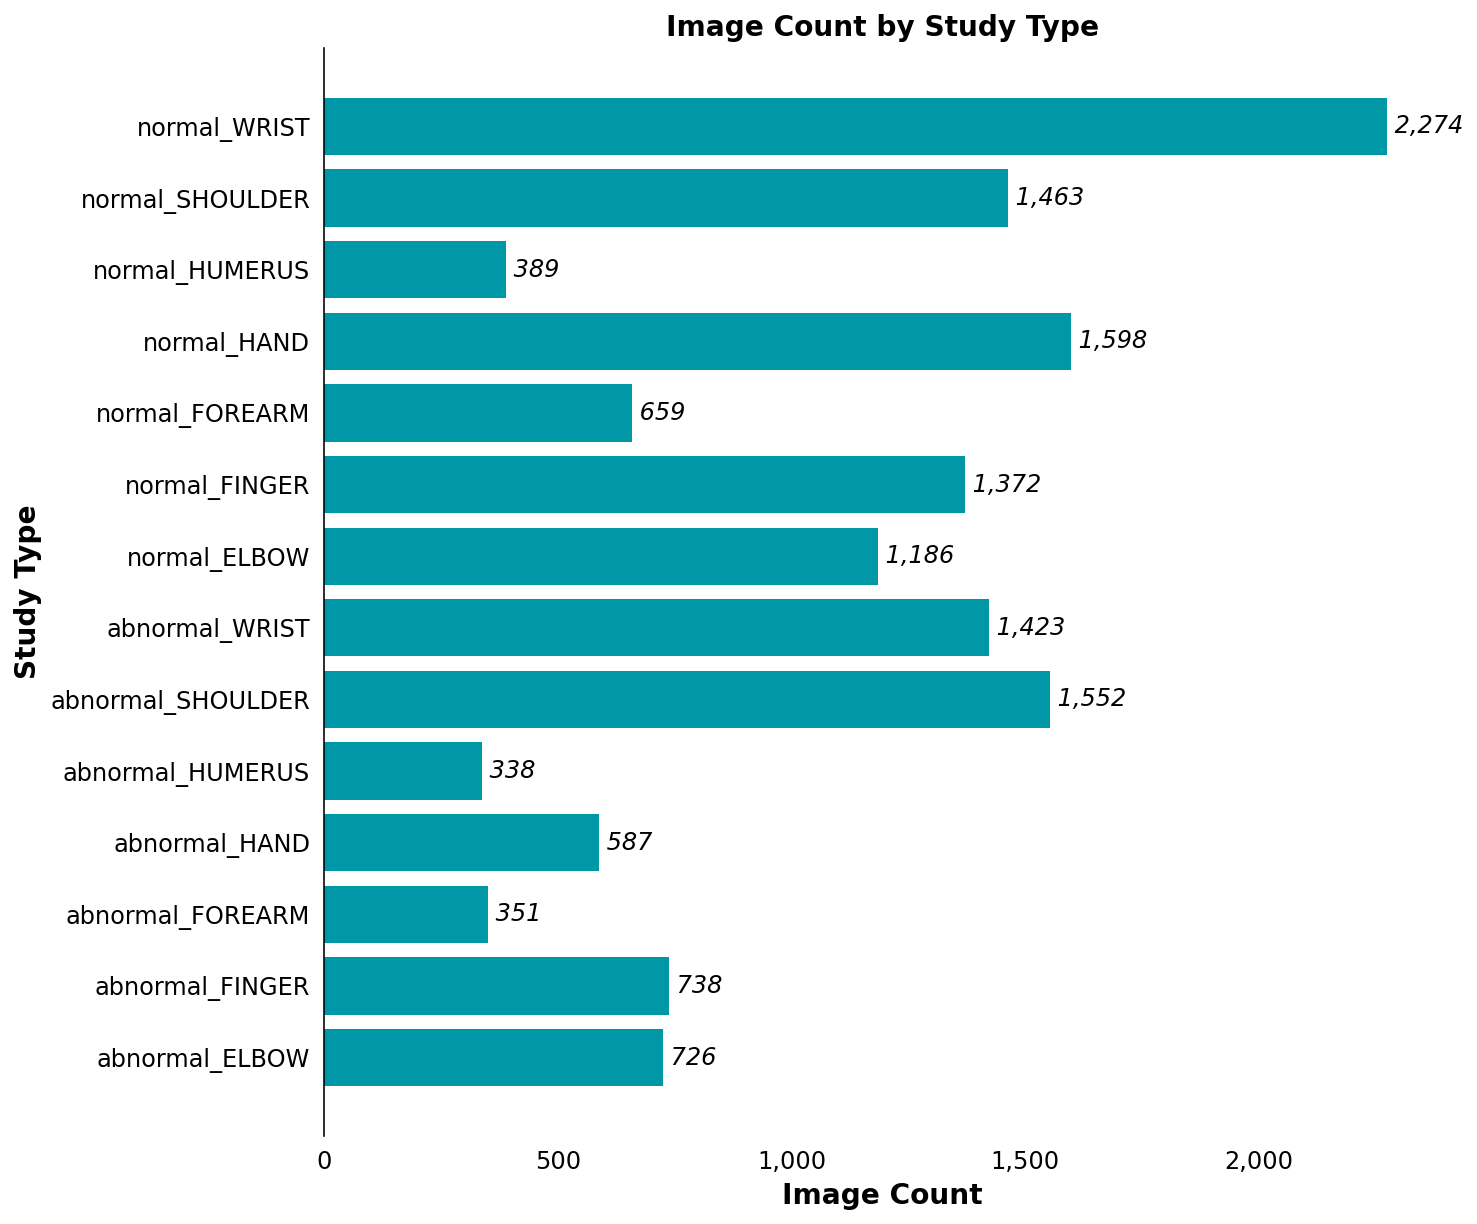

In [104]:
study_type_count_14(all_data_14)

In [105]:
#region count and visualisation
def region_count_14(df):
  # patient count by body part
  bdpt_df = df.groupby('type').count()['image_path'].reset_index()
  bdpt_df.columns = ['Region','Count']
  display(bdpt_df)

  # patient count by body part bargraph
  fig, ax = plt.subplots(figsize = (8,8))

  ax.barh(bdpt_df['Region'], bdpt_df['Count'], color = '#A8D3E3')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  plt.tick_params(left = False, bottom = False)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Region', fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.title('Image Count by Region', fontsize = 14, weight = 'bold')
  plt.show()
  return

,Region,Count
0,abnormal_ELBOW,66
1,abnormal_FINGER,83
2,abnormal_FOREARM,64
3,abnormal_HAND,66
4,abnormal_HUMERUS,67
5,abnormal_SHOULDER,95
6,abnormal_WRIST,97
7,normal_ELBOW,92
8,normal_FINGER,92
9,normal_FOREARM,69


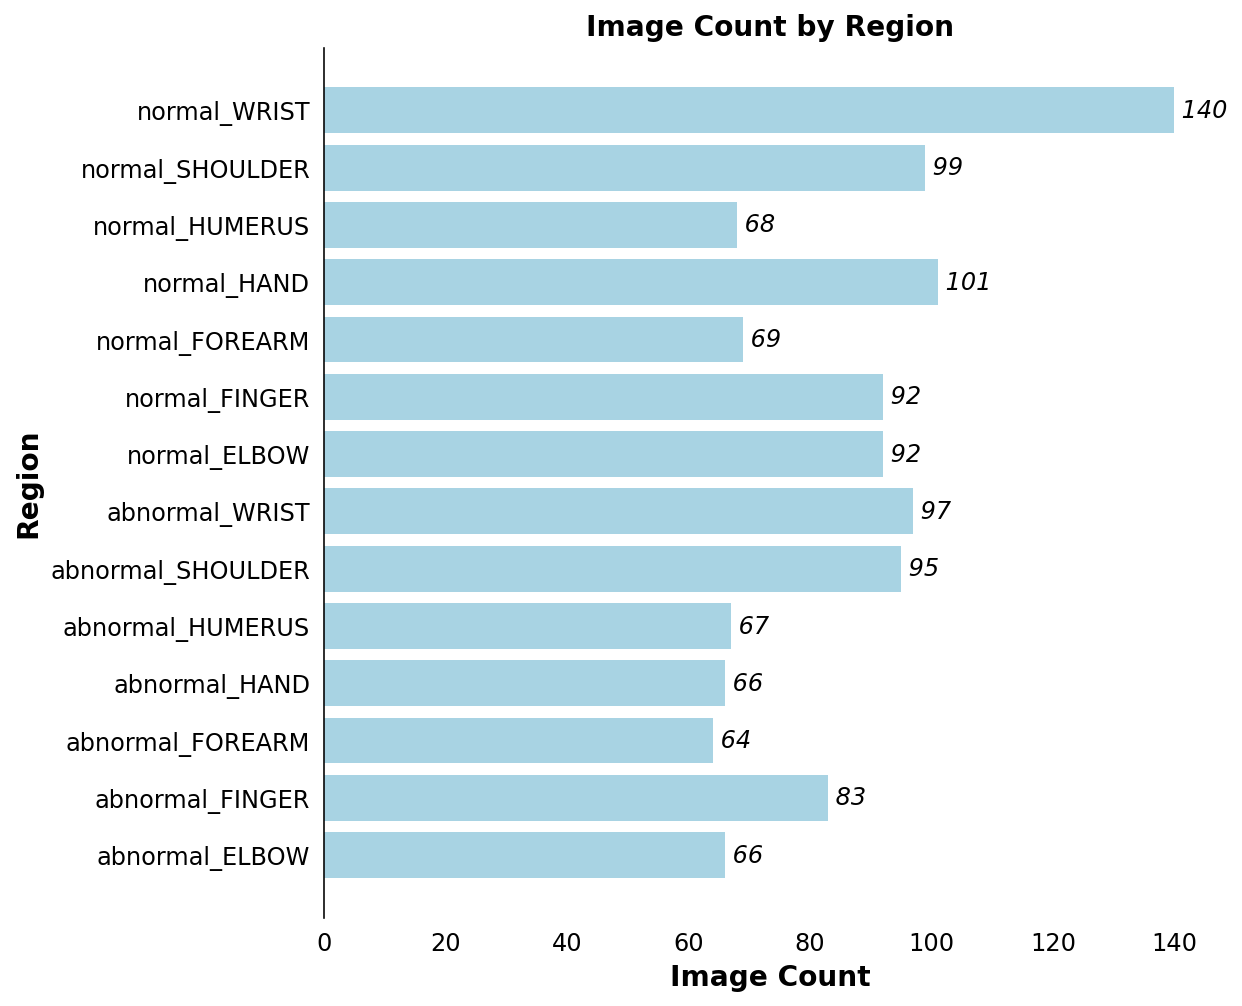

In [106]:
region_count_14(test_14)

In [107]:
# patient count by study type and region with visulization
def type_region_14(df):  
  stack = df.groupby(['region', 'study_type']).count()['image_path'].reset_index()
  stack.columns = ['Region','Study Type','Count']
  stack_neg = stack[stack['Study Type'] == 'normal']
  stack_pos = stack[stack['Study Type'] == 'abnormal']
  stack_all = stack_pos.merge(stack_neg, on = 'Region', how = 'left')
  stack_all['Count_z'] = stack_all['Count_x'] + stack_all['Count_y']
  display(stack_all)

  # patient count by study type and region stacked bargraph
  fig, ax = plt.subplots(figsize = (8,8))

  x = stack_all['Region']
  y1 = stack_all['Count_x']
  y2 = stack_all['Count_y']
  y3 = stack_all['Count_z']
  
  ax.barh(x, y1, color = '#A8D3E3', label = 'Abnormal')
  ax.barh(x, y2, left = y1, color = '#0097a7', label = 'Normal')
  container = ax.containers[0]
  container2 = ax.containers[1]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12, label_type = 'center')
  ax.bar_label(container2, labels = [' ' + f'{x:,.0f}' for x in container2.datavalues], style = 'italic', fontsize = 12, label_type = 'center')
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Region', fontsize = 14, weight = 'bold')
  ax.set_yticks(x, rotation = 90)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.tick_params(left = False, bottom = False)
  plt.title('Image Count by Study Type and Region', fontsize = 14, weight = 'bold')
  ax.legend()

  plt.show()
  return

,Region,Study Type_x,Count_x,Study Type_y,Count_y,Count_z
0,ELBOW,abnormal,726,normal,1186,1912
1,FINGER,abnormal,738,normal,1372,2110
2,FOREARM,abnormal,351,normal,659,1010
3,HAND,abnormal,587,normal,1598,2185
4,HUMERUS,abnormal,338,normal,389,727
5,SHOULDER,abnormal,1552,normal,1463,3015
6,WRIST,abnormal,1423,normal,2274,3697


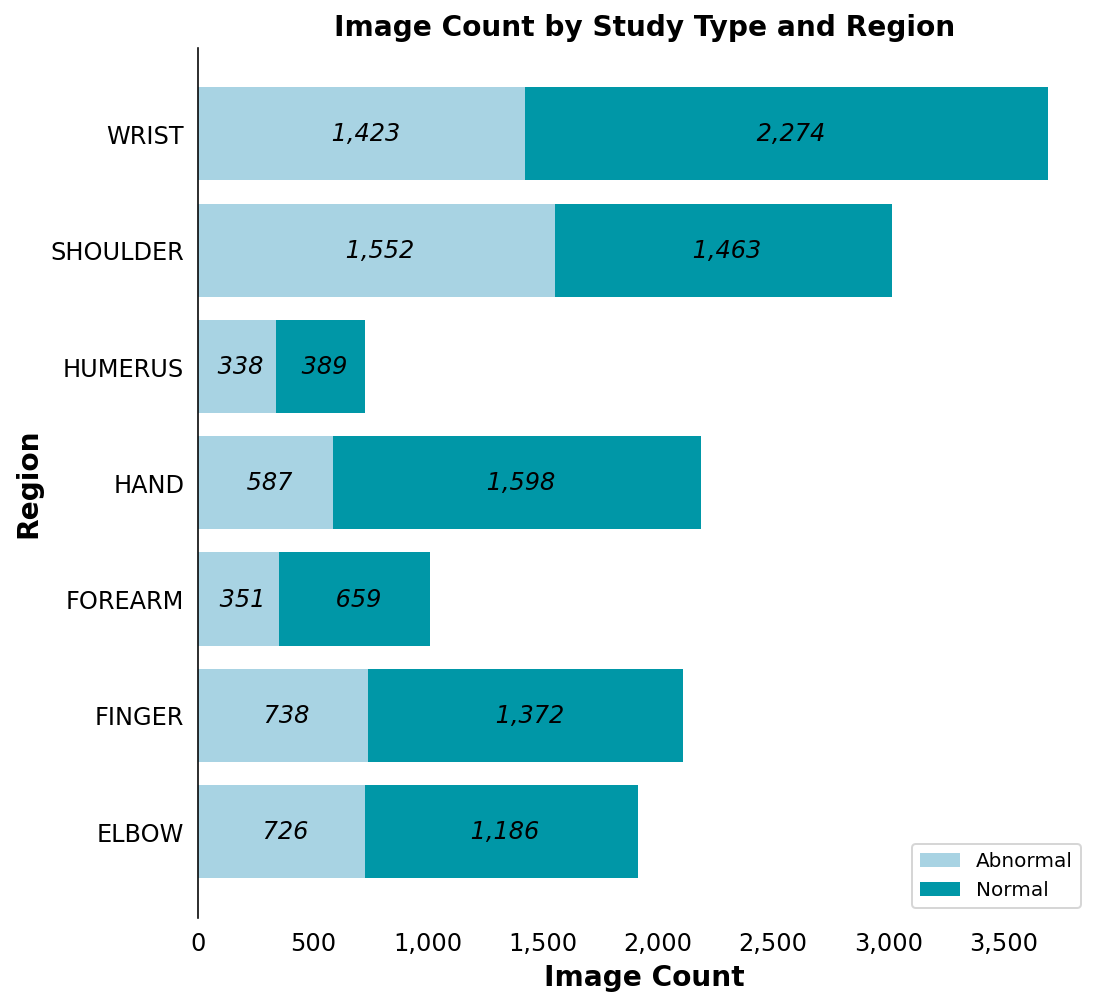

In [108]:
type_region_14(all_data_14)

# Data Preprocessing

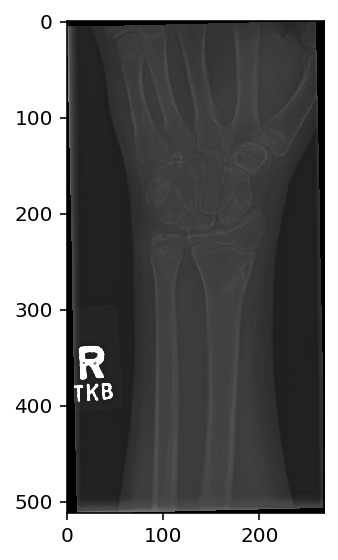

In [109]:
io.imshow(test.iloc[0,0] + 'image1.png')

In [110]:
test[test['study'] == 4]

,image_path,patient_id,study,study_type,region,target
107,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study4_negative/,patient11272,4,normal,WRIST,normal


In [111]:
test[test['patient_id'] == 'patient11272']

,image_path,patient_id,study,study_type,region,target
104,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study1_positive/,patient11272,1,abnormal,WRIST,abnormal
105,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study2_negative/,patient11272,2,normal,WRIST,normal
106,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study3_negative/,patient11272,3,normal,WRIST,normal
107,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study4_negative/,patient11272,4,normal,WRIST,normal
864,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11272/study1_negative/,patient11272,1,normal,SHOULDER,normal
1106,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11272/study1_positive/,patient11272,1,abnormal,FINGER,abnormal


In [112]:
test[test['study'] == 3]

,image_path,patient_id,study,study_type,region,target
3,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/,patient11186,3,abnormal,WRIST,abnormal
51,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11227/study3_negative/,patient11227,3,normal,WRIST,normal
95,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11264/study3_negative/,patient11264,3,normal,WRIST,normal
106,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study3_negative/,patient11272,3,normal,WRIST,normal
270,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11418/study3_negative/,patient11418,3,normal,FOREARM,normal
480,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11218/study3_negative/,patient11218,3,normal,HAND,normal
691,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11707/study3_negative/,patient11707,3,normal,SHOULDER,normal
711,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11417/study3_negative/,patient11417,3,normal,SHOULDER,normal
723,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11300/study3_negative/,patient11300,3,normal,SHOULDER,normal
1105,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11300/study3_negative/,patient11300,3,normal,FINGER,normal


In [113]:
test[test['patient_id'] == 'patient11186']

,image_path,patient_id,study,study_type,region,target
1,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,patient11186,1,abnormal,WRIST,abnormal
2,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/,patient11186,2,abnormal,WRIST,abnormal
3,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/,patient11186,3,abnormal,WRIST,abnormal
548,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11186/study1_positive/,patient11186,1,abnormal,HUMERUS,abnormal
697,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11186/study1_positive/,patient11186,1,abnormal,SHOULDER,abnormal
872,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/,patient11186,1,abnormal,ELBOW,abnormal


In [114]:
test[test['patient_id'] == 'patient11300']

,image_path,patient_id,study,study_type,region,target
137,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11300/study1_negative/,patient11300,1,normal,WRIST,normal
459,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11300/study1_negative/,patient11300,1,normal,HAND,normal
721,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11300/study1_positive/,patient11300,1,abnormal,SHOULDER,abnormal
722,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11300/study2_positive/,patient11300,2,abnormal,SHOULDER,abnormal
723,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11300/study3_negative/,patient11300,3,normal,SHOULDER,normal
1103,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11300/study1_positive/,patient11300,1,abnormal,FINGER,abnormal
1104,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11300/study2_negative/,patient11300,2,normal,FINGER,normal
1105,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11300/study3_negative/,patient11300,3,normal,FINGER,normal


In [115]:
path = test.iloc[107,0]
f = os.listdir(path)
print(f)

['image3.png', 'image1.png', 'image2.png']


In [116]:
images = []
for i, img in enumerate(os.listdir(path)):
  images.append(io.imread(path + img))

In [117]:
images

[array([[ 0,  0,  0, ..., 74, 74, 75],
        [ 0,  0,  0, ..., 74, 74, 74],
        [ 0,  0,  0, ..., 72, 71, 71],
        ...,
        [44, 40, 36, ..., 37, 36, 36],
        [45, 40, 36, ..., 36, 36, 36],
        [45, 40, 36, ..., 36, 35, 36]], dtype=uint8),
 array([[ 0,  0,  0, ..., 63, 66, 66],
        [ 0,  0,  0, ..., 62, 63, 64],
        [41, 42, 42, ..., 59, 61, 60],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 array([[ 0,  0,  0, ..., 51, 49, 48],
        [ 0,  0,  0, ..., 51, 45, 45],
        [ 0,  0,  0, ..., 49, 45, 44],
        ...,
        [29, 30, 30, ...,  0,  0,  0],
        [29, 29, 29, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)]

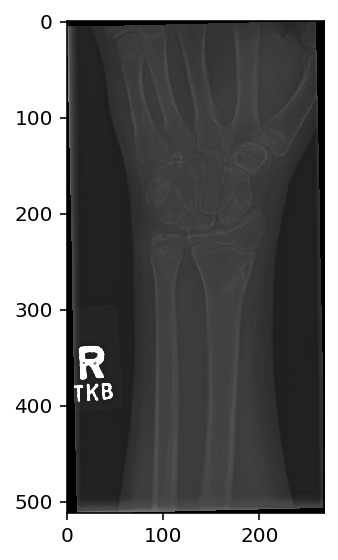

In [118]:
a = io.imread(test.iloc[0,0] + 'image1.png')
io.imshow(a)

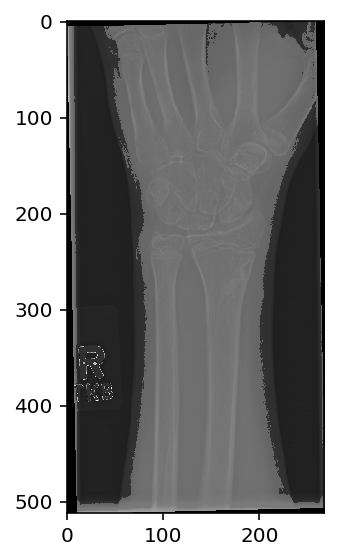

In [119]:
a[a>50] +=50
io.imshow(a)

In [120]:
a.shape

(512, 268)

In [121]:
b = read_image(test.iloc[0,0] + 'image1.png')

In [122]:
b

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [123]:
b.shape

torch.Size([1, 512, 268])

In [124]:
def pull_images_target(df):
  new_df = pd.DataFrame(columns=['image', 'target'])
  for i in range(len(df)):
    path = df.iloc[i]['image_path']
    target = df.iloc[i]['target']
    f = os.listdir(path)
    for j in range(len(f)):
      new_path = path + f[j] 
      new_df.loc[len(new_df)] = [new_path, target]
  return new_df

In [125]:
pd.set_option('max_colwidth', 400)
p = pull_images_target(test[0:20])
p.head()

,image,target
0,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,abnormal
1,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,abnormal
2,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,abnormal
3,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,abnormal
4,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,abnormal


In [126]:
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#https://blog.paperspace.com/working-with-custom-image-datasets-in-pytorch/

class MuraDataset(Dataset):
    def __init__(self, mura_df, transform=None):
        self.mura_df = mura_df
        self.transform = transform

    def __len__(self):
        return len(self.mura_df)

    def __getitem__(self, idx):
        image = read_image(mura_df.iloc[idx]['image_path'])
        label = mura_df.iloc[idx]['target']

        if self.transform:
            image = self.transform(sample)

        return image, label


In [127]:
#test_data = MuraDataset(pull_images_target(test))
#train_data = MuraDataset(pull_images_target(train))

In [129]:
#train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=1, shuffle=False)